In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# 讀取降雨觀測資料

In [2]:
with sqlite3.connect('obs_rainfall.sqlite') as conn:
    df_rain = pd.read_sql_query('SELECT stationName, stationID, lon, lat, obsTime, rain12hr FROM rainobs', conn)
    
df_rain['obsTime'] = pd.to_datetime(df_rain['obsTime']).dt.tz_localize(None)
df_rain.head()

,stationName,stationId,lon,lat,obsTime,rain12hr
0,九份二山,C1I230,120.8369,23.9637,2019-08-29 18:50:00,0.00
1,基隆,466940,121.7323,25.1351,2019-08-29 18:50:00,0.00
2,淡水,466900,121.4407,25.1667,2019-08-29 18:50:00,0.00
3,板橋,466880,121.4338,24.9994,2019-08-29 18:50:00,0.00
4,陽明山,466930,121.5363,25.1639,2019-08-29 18:50:00,0.00


In [3]:
df_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3954130 entries, 0 to 3954129
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   stationName  object        
 1   stationId    object        
 2   lon          object        
 3   lat          object        
 4   obsTime      datetime64[ns]
 5   rain12hr     object        
dtypes: datetime64[ns](1), object(5)
memory usage: 181.0+ MB


In [5]:
dt = pd.DatetimeIndex(df_rain['obsTime'])
df_rain = df_rain[(dt.hour == 18) & (dt.minute == 0)].copy()

df_rain[['lon', 'lat', 'rain12hr']] = df_rain[['lon', 'lat', 'rain12hr']].astype(float)
df_rain.loc[df_rain.rain12hr < 0, 'rain12hr'] = 0

df_rain.head()

# 同個測站，可能會有不同的經緯度座標 (可能是因為自動站的位置更換?)

,stationName,stationId,lon,lat,obsTime,rain12hr
22227,九份二山,C1I230,120.8369,23.9637,2019-08-30 18:00:00,2.0
22228,基隆,466940,121.7323,25.1351,2019-08-30 18:00:00,0.5
22229,淡水,466900,121.4407,25.1667,2019-08-30 18:00:00,14.5
22230,板橋,466880,121.4338,24.9994,2019-08-30 18:00:00,39.0
22231,陽明山,466930,121.5363,25.1639,2019-08-30 18:00:00,2.0


In [6]:
df_rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149039 entries, 22227 to 3933809
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   stationName  149039 non-null  object        
 1   stationId    149039 non-null  object        
 2   lon          149039 non-null  float64       
 3   lat          149039 non-null  float64       
 4   obsTime      149039 non-null  datetime64[ns]
 5   rain12hr     149039 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 8.0+ MB


# 尋找離縣(市)政府位置最近的觀測站

In [7]:
county_lonlat = pd.read_csv('county_lonlat.csv', header=None, index_col=0)
county_lonlat.head()

,1,2
0,,
臺北市,25.037591,121.564470
新北市,25.012311,121.465590
桃園市,24.993220,121.301106
臺中市,24.161957,120.647116
臺南市,22.992227,120.185172


In [8]:
def latlon2distance(lonlat1, lonlat2):
    """
    Calculate the distance (km) between two points in longitude/latitude coordinate.
    Units of parameters are degree.
    """
    R = 6373.0    # approximate radius of earth (km)
    
    lon1, lat1 = np.radians(lonlat1)
    lon2, lat2 = np.radians(lonlat2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [10]:
nearest_station = []    # List[List[datetime, county_name, nearest_station, distance]]

for dt in df_rain['obsTime'].unique():
    print(pd.to_datetime(dt).strftime('%Y-%m-%d'), end='  ')
    dftmp = df_rain[df_rain['obsTime'] == dt]
    
    for county_name, val in county_lonlat.iterrows():
        lonlat = tuple(val)[::-1]
        dist = dftmp[['lon', 'lat']].apply(lambda row: latlon2distance(lonlat, tuple(row)), axis=1)
        
        idx = dist.argmin()
        station_name = dftmp.iloc[idx,0]
        station_id = dftmp.iloc[idx,1]
        mindist = dist.iloc[idx]
        nearest_station.append([dt, county_name, station_name, station_id, mindist])

2019-08-30  2019-08-31  2019-09-01  2019-09-02  2019-09-03  2019-09-05  2019-09-06  2019-09-07  2019-09-08  2019-09-09  2019-09-10  2019-09-11  2019-09-12  2019-09-13  2019-09-16  2019-09-17  2019-09-18  2019-09-19  2019-09-20  2019-09-21  2019-09-22  2019-09-24  2019-09-25  2019-09-26  2019-09-27  2019-09-29  2019-10-01  2019-10-02  2019-10-03  2019-10-04  2019-10-05  2019-10-06  2019-10-07  2019-10-08  2019-10-09  2019-10-10  2019-10-11  2019-10-12  2019-10-13  2019-10-14  2019-10-15  2019-10-16  2019-10-17  2019-10-18  2019-10-19  2019-10-20  2019-10-21  2019-10-22  2019-10-23  2019-10-24  2019-10-25  2019-10-26  2019-10-27  2019-10-28  2019-10-29  2019-10-30  2019-10-31  2019-11-02  2019-11-03  2019-11-04  2019-11-06  2019-11-07  2019-11-08  2019-11-09  2019-11-10  2019-11-11  2019-11-12  2019-11-13  2019-11-14  2019-11-15  2019-11-16  2019-11-17  2019-11-18  2019-11-19  2019-11-20  2019-11-21  2019-11-22  2019-11-23  2019-11-24  2019-11-25  2019-11-26  2019-11-27  2019-11-28  2019

In [11]:
nearest_station = pd.DataFrame(nearest_station, columns=['obsTime', 'county', 'stationName', 'stationID', 'dist'])
nearest_station

,obsTime,county,stationName,stationID,dist
0,2019-08-30 18:00:00,臺北市,信義,C0AC70,0.843446
1,2019-08-30 18:00:00,新北市,中和,C0AG90,2.593903
2,2019-08-30 18:00:00,桃園市,中壢,C0C700,5.551046
3,2019-08-30 18:00:00,臺中市,西屯,C0F9T0,2.655405
4,2019-08-30 18:00:00,臺南市,臺南,467410,1.220055
...,...,...,...,...,...
3471,2020-02-20 18:00:00,花蓮縣,花蓮,466990,2.206050
3472,2020-02-20 18:00:00,臺東縣,台東(7),01S610,0.041253
3473,2020-02-20 18:00:00,澎湖縣,澎湖,467350,1.202894
3474,2020-02-20 18:00:00,金門縣,金寧,C0W150,2.450145


# 讀取縣市預報資料 (只考慮 05:00 時對 06:00 至 18:00 的預報)

In [12]:
with sqlite3.connect('county_36hr_forecast.sqlite') as conn:
    df_fcst = pd.read_sql_query('SELECT * FROM county', conn)

df_fcst = df_fcst.loc[df_fcst['element'] == 'PoP', ['location', 'issueTime', 'startTime', 'endTime', 'value']]

for time_type in ['issueTime', 'startTime', 'endTime']:
    df_fcst[time_type] = pd.to_datetime(df_fcst[time_type]).dt.tz_localize(None)
    
cond1 = pd.DatetimeIndex(df_fcst['issueTime']).hour == 5
cond2 = pd.DatetimeIndex(df_fcst['startTime']).hour == 6
cond3 = pd.DatetimeIndex(df_fcst['endTime']).hour == 18
df_fcst = df_fcst[cond1 & cond2 & cond3]

df_fcst['lead_time'] = df_fcst['startTime'] - df_fcst['issueTime']

df_fcst.head()

,location,issueTime,startTime,endTime,value,lead_time
1002,臺北市,2019-08-29 05:00:00,2019-08-29 06:00:00,2019-08-29 18:00:00,40,0 days 01:00:00
1004,臺北市,2019-08-29 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,70,1 days 01:00:00
1017,新北市,2019-08-29 05:00:00,2019-08-29 06:00:00,2019-08-29 18:00:00,30,0 days 01:00:00
1019,新北市,2019-08-29 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,70,1 days 01:00:00
1032,桃園市,2019-08-29 05:00:00,2019-08-29 06:00:00,2019-08-29 18:00:00,30,0 days 01:00:00


In [13]:
df_fcst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7700 entries, 1002 to 231989
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   location   7700 non-null   object         
 1   issueTime  7700 non-null   datetime64[ns] 
 2   startTime  7700 non-null   datetime64[ns] 
 3   endTime    7700 non-null   datetime64[ns] 
 4   value      7700 non-null   object         
 5   lead_time  7700 non-null   timedelta64[ns]
dtypes: datetime64[ns](3), object(2), timedelta64[ns](1)
memory usage: 421.1+ KB


# 分析

In [17]:
df_analysis = pd.merge(df_fcst, nearest_station, left_on=['location', 'endTime'], right_on=['county', 'obsTime'])
df_analysis = df_analysis.drop(['obsTime', 'county', 'dist'], axis=1)
df_analysis

,location,issueTime,startTime,endTime,value,lead_time,stationName,stationID
0,臺北市,2019-08-29 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,70,1 days 01:00:00,信義,C0AC70
1,臺北市,2019-08-30 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,60,0 days 01:00:00,信義,C0AC70
2,新北市,2019-08-29 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,70,1 days 01:00:00,中和,C0AG90
3,新北市,2019-08-30 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,70,0 days 01:00:00,中和,C0AG90
4,桃園市,2019-08-29 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,60,1 days 01:00:00,中壢,C0C700
...,...,...,...,...,...,...,...,...
6881,澎湖縣,2020-02-20 05:00:00,2020-02-20 06:00:00,2020-02-20 18:00:00,0,0 days 01:00:00,澎湖,467350
6882,金門縣,2020-02-19 05:00:00,2020-02-20 06:00:00,2020-02-20 18:00:00,0,1 days 01:00:00,金寧,C0W150
6883,金門縣,2020-02-20 05:00:00,2020-02-20 06:00:00,2020-02-20 18:00:00,0,0 days 01:00:00,金寧,C0W150
6884,連江縣,2020-02-19 05:00:00,2020-02-20 06:00:00,2020-02-20 18:00:00,0,1 days 01:00:00,馬祖,467990


In [18]:
df_analysis = pd.merge(df_analysis, df_rain, left_on=['stationID', 'endTime'], right_on=['stationId', 'obsTime'])
df_analysis['israin'] = df_analysis['rain12hr'] > 0
df_analysis

,location,issueTime,startTime,endTime,value,lead_time,stationName_x,stationID,stationName_y,stationId,lon,lat,obsTime,rain12hr,israin
0,臺北市,2019-08-29 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,70,1 days 01:00:00,信義,C0AC70,信義,C0AC70,121.5564,25.0396,2019-08-30 18:00:00,1.0,True
1,臺北市,2019-08-30 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,60,0 days 01:00:00,信義,C0AC70,信義,C0AC70,121.5564,25.0396,2019-08-30 18:00:00,1.0,True
2,新北市,2019-08-29 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,70,1 days 01:00:00,中和,C0AG90,中和,C0AG90,121.4822,24.9945,2019-08-30 18:00:00,3.0,True
3,新北市,2019-08-30 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,70,0 days 01:00:00,中和,C0AG90,中和,C0AG90,121.4822,24.9945,2019-08-30 18:00:00,3.0,True
4,桃園市,2019-08-29 05:00:00,2019-08-30 06:00:00,2019-08-30 18:00:00,60,1 days 01:00:00,中壢,C0C700,中壢,C0C700,121.2482,24.9794,2019-08-30 18:00:00,33.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6881,澎湖縣,2020-02-20 05:00:00,2020-02-20 06:00:00,2020-02-20 18:00:00,0,0 days 01:00:00,澎湖,467350,澎湖,467350,119.5550,23.5672,2020-02-20 18:00:00,0.0,False
6882,金門縣,2020-02-19 05:00:00,2020-02-20 06:00:00,2020-02-20 18:00:00,0,1 days 01:00:00,金寧,C0W150,金寧,C0W150,118.3208,24.4593,2020-02-20 18:00:00,0.0,False
6883,金門縣,2020-02-20 05:00:00,2020-02-20 06:00:00,2020-02-20 18:00:00,0,0 days 01:00:00,金寧,C0W150,金寧,C0W150,118.3208,24.4593,2020-02-20 18:00:00,0.0,False
6884,連江縣,2020-02-19 05:00:00,2020-02-20 06:00:00,2020-02-20 18:00:00,0,1 days 01:00:00,馬祖,467990,馬祖,467990,119.9151,26.1710,2020-02-20 18:00:00,0.0,False


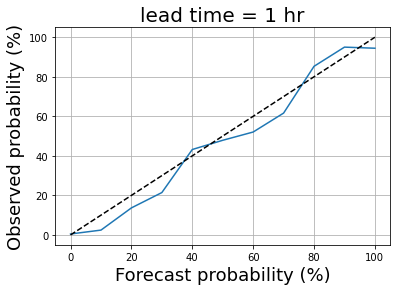

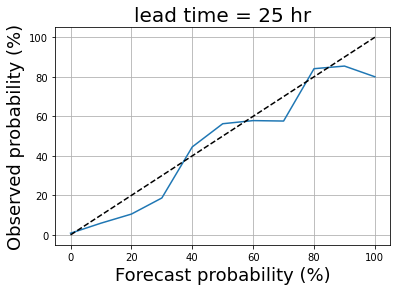

In [98]:
for leadtime in [1, 25]:
    idx = df_analysis['lead_time'] == pd.to_timedelta(leadtime, unit='hr')
    res = df_analysis.loc[idx, ['value', 'israin']].groupby('value').mean()
    res.index = res.index.astype(int)
    res = res.sort_index()

    plt.figure()
    plt.plot(res.index, res.israin * 100)
    plt.plot([0, 100], [0, 100], 'k--')
    plt.grid()
    plt.xlabel('Forecast probability (%)', fontsize=18)
    plt.ylabel('Observed probability (%)', fontsize=18)
    plt.title(f'lead time = {leadtime} hr', fontsize=20)

# 依地區分類

In [90]:
idx = df_analysis['lead_time'] == pd.to_timedelta(1, unit='hr')
df_analysis.loc[idx, ['location', 'value', 'israin']].groupby(['location', 'value']).sum().loc['南投縣']

,israin
value,
0,0
10,2
100,1
20,0
30,0
50,1
60,2
70,2
80,2


In [99]:
df_analysis.loc[idx, ['location', 'value', 'israin']].groupby(['location', 'value']).count().loc['南投縣']

,israin
value,
0,105
10,22
100,1
20,10
30,2
40,3
50,3
60,3
70,3
